Entrenar un nuevo modelo (que no sea Random Forest ni el utilizado para el baseline) con búsqueda de hiperparametros (¿cómo conviene elegir los datos de validación respecto de los de train?). El modelo debe cumplir las siguientes condiciones:

* Deben utilizar AUC-ROC como métrica de validación.
* Deben medirse solo en validación, no contra test!!!
* Deben ser reproducibles (correr el notebook varias veces no afecta al resultado).
* Deben tener un score en validación superior a 0,9.
* Para el feature engineering debe utilizarse imputación de nulos, mean encoding y one hot encoding al menos una vez cada uno.
* Deben utilizar al menos 40 features (contando cómo features columnas con números, pueden venir varios de la misma variable).
* Deberán contestar la siguientes preguntas:
  * ¿Cuál es el score en test? (guardar el csv con predicciones para entregarlo después)
  * ¿Por qué cree que logro/no logro el mismo valor de AUC que con Random Forest?

***¿Cuál es el score en test? (guardar el csv con predicciones para entregarlo después)***

El score en test es de 0,9999977195235499.

***¿Por qué cree que logro/no logro el mismo valor de AUC que con Random Forest?***

Un AUC-ROC de 1 indica que el modelo puede hacer una clasificación perfecta.

La diferencia en el valor de AUC entre el nuevo modelo y Random Forest puede ser por varias razones: diferencias en el algoritmo, hiper-parámetros o caracteristicas especificas del conjunto de datos.

En primer lugar creo que logre el mismo valor (en clase se comento que un 0,99999... puede considerarse como 1.) de AUC que con Random Forest debido principalmente a caracteristicas especificas del conjunto de datos. ¿A que nos referimos con esto?. Viendo el analisis hecho en la parte I, mas especificamente en el analisis hecho a los Scatter Plot, podemos entender esto mejor.

Basicamente, hay una clara separación entre las clases en función de algunas de las características. Entonces, que las clases esten separadas en los gráficos de dispersión nos dice que es posible que un clasificador como Random Forest o XGBoost puedan lograr un AUC de 1.

En segundo lugar, creo que tiene que ver con que ambos algoritmos son algoritmos de aprendizaje automatico basado en arboles de decision. Entonces tanto Random Forest como XGBoost pueden capturar patrones y relaciones en los datos.

Cuando las clases están claramente separadas en los gráficos de dispersión, esto significa que hay una alta discriminación entre las clases basada en las características. Entonces los árboles de decisión pueden aprender reglas que pueden clasificar perfectamente en función de esas características.

Por ejemplo, recordemos lo que decimos en el analisis hecho en la parte I. Al tener clara separación entre las clases en función de las características, un arbol puede aprender facilmente que si tiene mas de 60 de ancho o mas de 35 de diametro un hongo es comestible (ver el grafico de dispersion en funcion de stem-width y cap-diameter).



In [ ]:
!pip install category_encoders
!pip install scikit-plot

In [59]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from category_encoders.binary import BinaryEncoder
import xgboost as xgb
from sklearn.metrics import classification_report
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
import pickle

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
df = pd.read_csv("/content/drive/MyDrive/Organizacion de Datos/Colab Notebooks/TP2/secondary_data.csv", sep=';')

# Division del set de datos

Set de entrenamiento (train set): Se usa para entrenar los diferentes modelos (80%)

Set de validación (validation set): Se usa para medir la performance de los diferentes modelos con los que se entrena (10%)

Set de testeo (test set): Se usa para medir la performance del modelo final (10%)


In [61]:
X = df.iloc[:,1:]
y = df.iloc[:,0:1]

X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.2, random_state=123)

X_validation, X_test, y_validation, y_test = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=123)

# Imputacion de nulos

## Analisis

A continuacion vemos que tenemos NaNs en las siguientes columnas: cap-surface, gill-attachment, gill-spacing, stem-root, stem-surface, veil-type, veil-color, ring-type, spore-print-color.

¿Que features tienen menos del 25% de valores no nulos?: stem-root (15% no nulos), veil-type (5%), veil-color(12%), spore-print-color (10%).

In [62]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48855 entries, 19898 to 52734
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cap-diameter          48855 non-null  float64
 1   cap-shape             48855 non-null  object 
 2   cap-surface           37613 non-null  object 
 3   cap-color             48855 non-null  object 
 4   does-bruise-or-bleed  48855 non-null  object 
 5   gill-attachment       40938 non-null  object 
 6   gill-spacing          28833 non-null  object 
 7   gill-color            48855 non-null  object 
 8   stem-height           48855 non-null  float64
 9   stem-width            48855 non-null  float64
 10  stem-root             7621 non-null   object 
 11  stem-surface          18341 non-null  object 
 12  stem-color            48855 non-null  object 
 13  veil-type             2603 non-null   object 
 14  veil-color            5947 non-null   object 
 15  has-ring       

Comprobamos que efectivamente estas columnas tienen valores NaN.

In [63]:
X_train["cap-surface"].isna().any(), X_train["gill-attachment"].isna().any(), X_train["gill-spacing"].isna().any(), X_train["stem-root"].isna().any(), X_train["stem-surface"].isna().any(), \
X_train["veil-type"].isna().any(), X_train["veil-color"].isna().any(), X_train["ring-type"].isna().any(), X_train["spore-print-color"].isna().any()

(True, True, True, True, True, True, True, True, True)

Para cada una de estas columnas vemos sus distintos valores unicos y hacemos un pequeño analisis teniendo en cuenta la informacion de cada columna que nos proporciona la pagina del dataset.

* cap-surface: Tenemos un valor "d" que no aparece en la informacion del dataset. Además, no tenemos ningun valor para los None como los otros casos donde "f" = None.


In [64]:
X_train["cap-surface"].unique()

array(['i', nan, 't', 'k', 'y', 'g', 'e', 's', 'd', 'l', 'h', 'w'],
      dtype=object)

* gill-attachment: Por la informacion del dataset sabemos que tenemos un valor "f" = None y también tenemos un valor unknown.

In [65]:
X_train["gill-attachment"].unique()

array(['e', 'a', 'x', 'd', 's', nan, 'f', 'p'], dtype=object)

* gill-spacing: Por la informacion del dataset sabemos que tenemos un valor "f" = None.

In [66]:
X_train["gill-spacing"].unique()

array([nan, 'c', 'f', 'd'], dtype=object)

* stem-root: Tenemos un valor "f" que no aparece en la informacion de los atributos. ¿Podria ser "f" = None como los otros casos?. Asumimos que si.

In [67]:
X_train["stem-root"].unique()

array([nan, 'b', 'f', 's', 'r', 'c'], dtype=object)

* stem-surface: Por la informacion del dataset sabemos que tenemos un valor "f" = None.

In [68]:
X_train["stem-surface"].unique()

array([nan, 's', 'i', 'f', 'k', 'y', 't', 'g', 'h'], dtype=object)

* veil-type: Por la informacion del dataset sabemos que esta feature tiene dos valores posibles que son "u" y "p". Sin embargo, notemos que no hay ningun registro que tenga un hongo con un tipo de velo "p". 

In [69]:
X_train["veil-type"].unique()

array([nan, 'u'], dtype=object)

* veil-color: Por la informacion del dataset sabemos que tenemos un valor "f" = None. Sin embargo, notemos que no hay ningun registro que tenga un hongo con color de velo igual a "f".

In [70]:
X_train["veil-color"].unique()

array([nan, 'w', 'n', 'u', 'y', 'e', 'k'], dtype=object)

* ring-type: Por la informacion del dataset sabemos que tenemos un valor "f" = None y también tenemos un valor unknown.

In [71]:
X_train["ring-type"].unique()

array(['f', 'z', nan, 'p', 'e', 'r', 'l', 'm', 'g'], dtype=object)

* spore-print-color: No tenemos ningun valor para los None como los otros casos donde f = "None".

In [72]:
X_train["spore-print-color"].unique()

array([nan, 'k', 'r', 'w', 'p', 'n', 'g', 'u'], dtype=object)

Nos podemos preguntar en cada caso que pasa con estos NaN. Podriamos asumir que los NaN son valores "f" en aquellos casos donde por la informacion del dataset sabemos que existe el valor "f" = None. Sin embargo, nada nos asegura que estos valores faltantes representen exactamente esto. 

Ademas, en los casos donde tenemos valores "f" y valores nulos, ¿si se estaba usando "f" para los valores nulos por que no completaron todo el conjunto de datos con este valor y dejaron los NaN?. Asumo que esto lo hicieron asi porque los NaN no representan exactamente un valor "f" ya que de ser asi hubiesen completado todos los registros con dicho valor.

Finalmente, considero que no es muy bueno asumir solo porque si que los valores NaN representan el valor "f".

Notemos que tenemos algunos casos particulares:

* Para el caso de gill-attachment y ring-type supondremos que aquellos valores NaN representan el valor "unknown" porque es mas barato a nivel dataset representar asi que es desconocido el valor de esta caracteristica para cierto hongo. Lo que haremos es imputar los nulos utilizando un valor constante (dicho valor sera "desconocido").

* Para el caso de veil-type donde tenemos unicamente dos valores posibles ("u" y "nan") lo que podemos hacer es utilizar One Hot Encoding tal que estos valores NaN queden representados como algo desconocido con un valor constante que podria ser 1 o 0. Es decir, asumimos los valores NaN como una clase.

* Para el caso de veil-color como sabemos que tenemos un valor "f" = None pero vimos que no hay ningun registro con este valor supondremos que aquellos valores NaN representan "f" = None porque es mas barato a nivel dataset representar asi que un cierto hongo no tiene esta caracteristica. Lo que haremos es imputar los nulos utilizando un valor constante (dicho valor sera "f").

* Antes vimos que hay features que tienen menos del 25% de valores no nulos: stem-root (15% no nulos), veil-type (5%), veil-color(12%), spore-print-color (10%). Para veil-type y veil-color ya hemos elegido un criterio. Luego, como en stem-root y spore-print-color tenemos muchos valores NaN lo que haremos es imputar los nulos utilizando un valor constante (dicho valor sera "otro").

Por ultimo, en cuanto a las features cap-surface, gill-spacing y stem-surface al tener mas del 25% de valores no nulos y al no tener la certeza de que los NaN sean valores "f" lo que haremos es imputar los nulos utilizando la moda (reemplazar los valores faltantes con el valor más frecuente en la variable categorica).


## Imputacion

**Resumen del analisis**

* Moda: cap-surface, gill-spacing y stem-surface.
* Valor constante: gill-attachment ("desconocido"), stem-root ("otro"), veil-color ("f"), ring-type ("desconocido"), spore-print-color ("otro").
* El caso de la feature veil-type es particular y asumimos los valores NaN como una clase.

In [73]:
imputer_cap_surface = SimpleImputer(strategy='most_frequent')

imputer_cap_surface.fit(X_train)

imputer_cap_surface_train = imputer_cap_surface.fit_transform(X_train[['cap-surface']])
imputer_cap_surface_validation = imputer_cap_surface.transform(X_validation[['cap-surface']])
imputer_cap_surface_test = imputer_cap_surface.transform(X_test[['cap-surface']])

X_train["cap-surface"] = imputer_cap_surface_train
X_validation["cap-surface"] = imputer_cap_surface_validation
X_test["cap-surface"] = imputer_cap_surface_test

In [74]:
imputer_gill_attachment = SimpleImputer(strategy='constant', fill_value="desconocido")

imputer_gill_attachment.fit(X_train)

imputer_gill_attachment_train = imputer_gill_attachment.fit_transform(X_train[['gill-attachment']])
imputer_gill_attachment_validation = imputer_gill_attachment.transform(X_validation[['gill-attachment']])
imputer_gill_attachment_test = imputer_gill_attachment.transform(X_test[['gill-attachment']])

X_train["gill-attachment"] = imputer_gill_attachment_train
X_validation["gill-attachment"] = imputer_gill_attachment_validation
X_test["gill-attachment"] = imputer_gill_attachment_test

In [75]:
imputer_gill_spacing = SimpleImputer(strategy='most_frequent')

imputer_gill_spacing.fit(X_train)

imputer_gill_spacing_train = imputer_gill_spacing.fit_transform(X_train[['gill-spacing']])
imputer_gill_spacing_validation = imputer_gill_spacing.transform(X_validation[['gill-spacing']])
imputer_gill_spacing_test = imputer_gill_spacing.transform(X_test[['gill-spacing']])

X_train["gill-spacing"] = imputer_gill_spacing_train
X_validation["gill-spacing"] = imputer_gill_spacing_validation
X_test["gill-spacing"] = imputer_gill_spacing_test

In [76]:
imputer_stem_root = SimpleImputer(strategy='constant', fill_value="otro")

imputer_stem_root.fit(X_train)

imputer_stem_root_train = imputer_stem_root.fit_transform(X_train[['stem-root']])
imputer_stem_root_validation = imputer_stem_root.transform(X_validation[['stem-root']])
imputer_stem_root_test = imputer_stem_root.transform(X_test[['stem-root']])

X_train["stem-root"] = imputer_stem_root_train
X_validation["stem-root"] = imputer_stem_root_validation
X_test["stem-root"] = imputer_stem_root_test

In [77]:
imputer_stem_surface = SimpleImputer(strategy='most_frequent')

imputer_stem_surface.fit(X_train)

imputer_stem_surface_train = imputer_stem_surface.fit_transform(X_train[['stem-surface']])
imputer_stem_surface_validation = imputer_stem_surface.transform(X_validation[['stem-surface']])
imputer_stem_surface_test = imputer_stem_surface.transform(X_test[['stem-surface']])

X_train["stem-surface"] = imputer_stem_surface_train
X_validation["stem-surface"] = imputer_stem_surface_validation
X_test["stem-surface"] = imputer_stem_surface_test

In [78]:
imputer_veil_color = SimpleImputer(strategy='constant', fill_value="f")

imputer_veil_color.fit(X_train)

imputer_veil_color_train = imputer_veil_color.fit_transform(X_train[['veil-color']])
imputer_veil_color_validation = imputer_veil_color.transform(X_validation[['veil-color']])
imputer_veil_color_test = imputer_veil_color.transform(X_test[['veil-color']])

X_train["veil-color"] = imputer_veil_color_train
X_validation["veil-color"] = imputer_veil_color_validation
X_test["veil-color"] = imputer_veil_color_test

In [79]:
imputer_ring_type = SimpleImputer(strategy='constant', fill_value="desconocido")

imputer_ring_type.fit(X_train)

imputer_ring_type_train = imputer_ring_type.fit_transform(X_train[['ring-type']])
imputer_ring_type_validation = imputer_ring_type.transform(X_validation[['ring-type']])
imputer_ring_type_test = imputer_ring_type.transform(X_test[['ring-type']])

X_train["ring-type"] = imputer_ring_type_train
X_validation["ring-type"] = imputer_ring_type_validation
X_test["ring-type"] = imputer_ring_type_test

In [80]:
imputer_spore_print_color = SimpleImputer(strategy='constant', fill_value="otro")

imputer_spore_print_color.fit(X_train)

imputer_spore_print_color_train = imputer_spore_print_color.fit_transform(X_train[['spore-print-color']])
imputer_spore_print_color_validation = imputer_spore_print_color.transform(X_validation[['spore-print-color']])
imputer_spore_print_color_test = imputer_spore_print_color.transform(X_test[['spore-print-color']])

X_train["spore-print-color"] = imputer_spore_print_color_train
X_validation["spore-print-color"] = imputer_spore_print_color_validation
X_test["spore-print-color"] = imputer_spore_print_color_test

Veamos a continuacion cuantos valores distintos tenemos para cada feature y en base a esto analicemos que encoding hacer en cada caso.

In [81]:
X_train["cap-shape"].nunique(), X_train["cap-surface"].nunique(), X_train["cap-color"].nunique(), X_train["does-bruise-or-bleed"].nunique(), X_train["gill-attachment"].nunique(), \
X_train["gill-spacing"].nunique(), X_train["gill-color"].nunique(), X_train["stem-root"].nunique(), X_train["stem-surface"].nunique(), X_train["stem-color"].nunique(), \
X_train["veil-type"].nunique(), X_train["veil-color"].nunique(), X_train["has-ring"].nunique(), X_train["ring-type"].nunique(), X_train["spore-print-color"].nunique(), \
X_train["habitat"].nunique(), X_train["season"].nunique()

(7, 11, 12, 2, 8, 3, 12, 6, 8, 13, 1, 7, 2, 9, 8, 8, 4)

Menor a 4 valores (One Hot Encoding): does-bruise-or-bleed, gill-spacing, veil-type, has-ring.

Entre 4 y 10 valores (Binary Encoding): cap-shape, gill-attachment, stem-root, stem-surface, veil-color, spore-print-color, ring-type, habitat, season.

Mayor a 10 valores (Mean Encoding): cap-surface, cap-color, gill-color, stem-color.


# Encoding

In [82]:
ohe_class = OneHotEncoder(drop='first')

encoded_class_train = ohe_class.fit_transform(y_train[['class']]).todense().astype(int)
encoded_class_validation = ohe_class.transform(y_validation[['class']]).todense().astype(int)
encoded_class_test = ohe_class.transform(y_test[['class']]).todense().astype(int)

y_train["class"] = encoded_class_train
y_validation["class"] = encoded_class_validation
y_test["class"] = encoded_class_test

## Mean Encoding (Smoothing)

In [83]:
mean_encoding = TargetEncoder(cols=["cap-surface", "cap-color", "gill-color", "stem-color"], smoothing=10)

X_train = mean_encoding.fit_transform(X_train, y_train)
X_validation = mean_encoding.transform(X_validation)
X_test = mean_encoding.transform(X_test)

## Binary Encoding

In [84]:
binary_encoding = BinaryEncoder(cols=["cap-shape", "gill-attachment", "stem-root", "stem-surface", "veil-color", "ring-type", "spore-print-color", "habitat", "season"])

X_train = binary_encoding.fit_transform(X_train)
X_validation = binary_encoding.transform(X_validation)
X_test = binary_encoding.transform(X_test)

## One Hot Encoding

In [85]:
ohe_bruise_or_bleed = OneHotEncoder(drop='first')

encoded_bruise_or_bleed_train = ohe_bruise_or_bleed.fit_transform(X_train[['does-bruise-or-bleed']]).todense().astype(int)
encoded_bruise_or_bleed_validation = ohe_bruise_or_bleed.transform(X_validation[['does-bruise-or-bleed']]).todense().astype(int)
encoded_bruise_or_bleed_test = ohe_bruise_or_bleed.transform(X_test[['does-bruise-or-bleed']]).todense().astype(int)

X_train["does-bruise-or-bleed"] = encoded_bruise_or_bleed_train
X_validation["does-bruise-or-bleed"] = encoded_bruise_or_bleed_validation
X_test["does-bruise-or-bleed"] = encoded_bruise_or_bleed_test

In [86]:
ohe_gill_spacing = OneHotEncoder()

encoded_gill_spacing_train = ohe_gill_spacing.fit_transform(X_train[['gill-spacing']]).todense().astype(int)
encoded_gill_spacing_validation = ohe_gill_spacing.transform(X_validation[['gill-spacing']]).todense().astype(int)
encoded_gill_spacing_test = ohe_gill_spacing.transform(X_test[['gill-spacing']]).todense().astype(int)

X_train = X_train.reset_index().drop(['index', 'gill-spacing'],axis=1).join(pd.DataFrame(encoded_gill_spacing_train).add_prefix('gill-spacing_'))
X_validation = X_validation.reset_index().drop(['index', 'gill-spacing'],axis=1).join(pd.DataFrame(encoded_gill_spacing_validation).add_prefix('gill-spacing_'))
X_test = X_test.reset_index().drop(['index', 'gill-spacing'],axis=1).join(pd.DataFrame(encoded_gill_spacing_test).add_prefix('gill-spacing_'))

In [87]:
ohe_veil_type = OneHotEncoder(drop='first')

encoded_veil_type_train = ohe_veil_type.fit_transform(X_train[['veil-type']]).todense().astype(int)
encoded_veil_type_validation = ohe_veil_type.transform(X_validation[['veil-type']]).todense().astype(int)
encoded_veil_type_test = ohe_veil_type.transform(X_test[['veil-type']]).todense().astype(int)

X_train["veil-type"] = encoded_veil_type_train
X_validation["veil-type"] = encoded_veil_type_validation
X_test["veil-type"] = encoded_veil_type_test

In [88]:
ohe_has_ring = OneHotEncoder(drop='first')

encoded_has_ring_train = ohe_has_ring.fit_transform(X_train[['has-ring']]).todense().astype(int)
encoded_has_ring_validation = ohe_has_ring.transform(X_validation[['has-ring']]).todense().astype(int)
encoded_has_ring_test = ohe_has_ring.transform(X_test[['has-ring']]).todense().astype(int)

X_train["has-ring"] = encoded_has_ring_train
X_validation["has-ring"] = encoded_has_ring_validation
X_test["has-ring"] = encoded_has_ring_test

# Primer modelo

## Introduccion

En este primer modelo no haremos busqueda de hiper-parametros. Entrenamos y predecimos con hiper-parámetros por defecto.

## XGBoost

Hiper-parámetros

* **learning_rate:** tasa de aprendizaje
* **max_depth:** máxima profundidad de cada árbol
* **subsample:** porcentaje de muestras usadas para cada árbol (valor muy bajo, posible underfitting)
* **colsample_bytree:** porcentaje de features usadas para cada árbol (valores muy alto, posible overfitting)
* **n_estimators:** cantidad de árboles a construir.
* **objective:** función de error a utilizar (algunas: reg:squarederror para regresión, reg:logistic o binary:logistic para clasificación)

Parámetros de regularización:

* **gamma:** umbral para hacer split basado en la reducción de error de hacer el nuevo split.
* **alpha:** regularización para los pesos de las hojas. Un valor más alto genera una mayor regularización.
* **lambda:** similar alpha pero para la sintonia fina.

Utilizamos un Random-Search que utiliza Cross Validation para la busqueda de hiper-parametros.

In [89]:
model = xgb.XGBClassifier(random_state=123)

In [90]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, ...)

## Score con AUC-ROC (en train y validation)

### Score de train

In [91]:
roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])

1.0

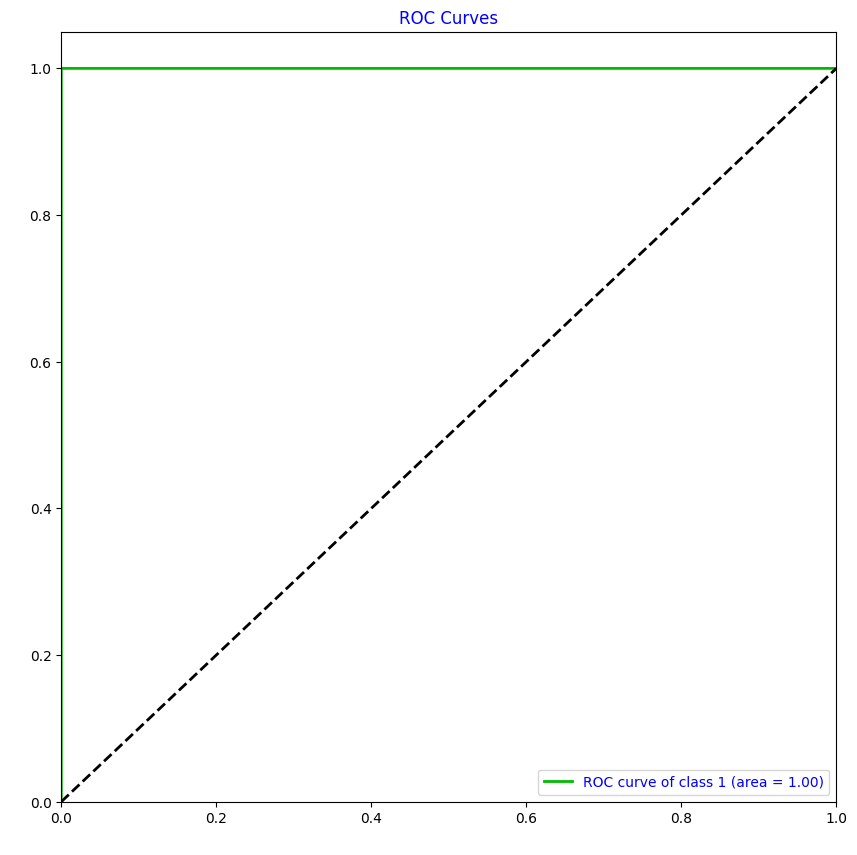

In [92]:
skplt.metrics.plot_roc(y_train, model.predict_proba(X_train), classes_to_plot= 1,plot_micro= False, plot_macro = False, figsize = (10,10))
plt.rcParams.update({'text.color': "blue", 'axes.labelcolor': "white"})

plt.show()

### Score de validacion

In [93]:
roc_auc_score(y_validation, model.predict_proba(X_validation)[:, 1])

1.0

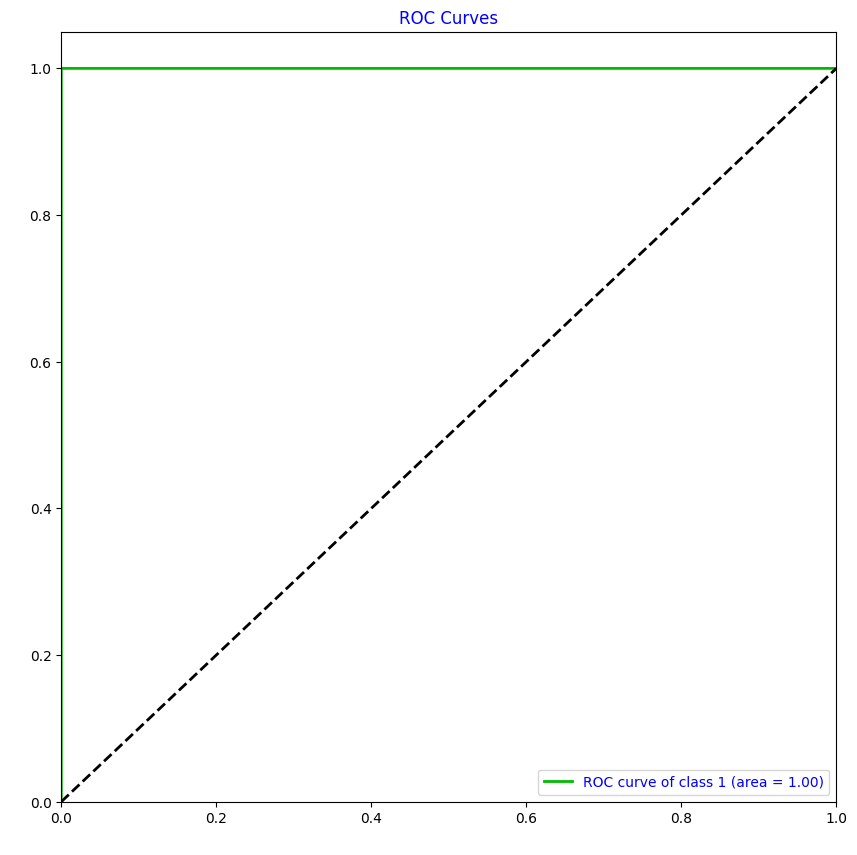

In [94]:
skplt.metrics.plot_roc(y_validation, model.predict_proba(X_validation), classes_to_plot= 1,plot_micro= False, plot_macro = False, figsize = (10,10))
plt.rcParams.update({'text.color': "blue", 'axes.labelcolor': "white"})

plt.show()

# Segundo modelo

## Introduccion

En este segundo modelo haremos busqueda de hiper-parametros. 

Nuestro objetivo con este segundo modelo es mejorar el score con AUC-ROC en validation.

## XGBoost

Hiper-parámetros

* **learning_rate:** tasa de aprendizaje
* **max_depth:** máxima profundidad de cada árbol
* **subsample:** porcentaje de muestras usadas para cada árbol (valor muy bajo, posible underfitting)
* **colsample_bytree:** porcentaje de features usadas para cada árbol (valores muy alto, posible overfitting)
* **n_estimators:** cantidad de árboles a construir.
* **objective:** función de error a utilizar (algunas: reg:squarederror para regresión, reg:logistic o binary:logistic para clasificación)

Parámetros de regularización:

* **gamma:** umbral para hacer split basado en la reducción de error de hacer el nuevo split.
* **alpha:** regularización para los pesos de las hojas. Un valor más alto genera una mayor regularización.
* **lambda:** similar alpha pero para la sintonia fina.

Utilizamos un Random-Search que utiliza Cross Validation para la busqueda de hiper-parametros.

In [95]:
xgb_model = xgb.XGBClassifier(random_state=123)

Definimos parametros para probar el modelo.

In [96]:
params = [
    {'learning_rate': [0.1,0.2,0.3]},
    {'max_depth': [5,10,15]},
    {'subsample': [0.8, 0.9, 1]},
    {'colsample_bytree': [0.3,0.6,0.9]},
    {'n_estimators': [10, 100, 150]},
    {'gamma': [5,10,15]},
    {'alpha': [5,10,15]},
    {'lambda': [5,10,15]},
] 

Buscamos la mejor combinacion de Hiper-Parametros tal que el scoring sea el mas optimo para la Curva ROC.

In [97]:
rs = RandomizedSearchCV(xgb_model, param_distributions=params, n_iter=5, cv=10, random_state=123, scoring='roc_auc')

In [98]:
rs.fit(X_train, y_train)

RandomizedSearchCV(cv=10,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rat...
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=123, ...),
                   n_iter=5,
                   param_distributions=[{'learning_rate': [0.1, 0.2, 0.3]},
                                        {'max_depth': [5, 10, 15]},
                                        {'subsample': [0.8, 0.9, 1]},
                                        {'colsample_bytree': [0.3, 0.6, 0.9]},
                                        {'n_estimators': [10, 100, 150]},
                                        {'gamma': [5, 10, 15]},
                                        {'alpha': [5, 10, 15]},
                                        {'lambda': [5, 10, 15]}],
                   random_state=123, scoring='roc_auc')

Vemos los mejores parametros que encontro. Notemos que para aquellos parametros que no aparecen tenemos que el mejor parametro es el valor default.

In [99]:
rs.best_params_

{'lambda': 5}

Nos quedamos con el modelo que tenga la mejor combinacion de Hiper-Parametros y lo entrenamos.

In [100]:
model = rs.best_estimator_
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=5, learning_rate=None,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...)

## Score con AUC-ROC (en train y validation)

### Score de train

In [101]:
roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])

0.9999999762441618

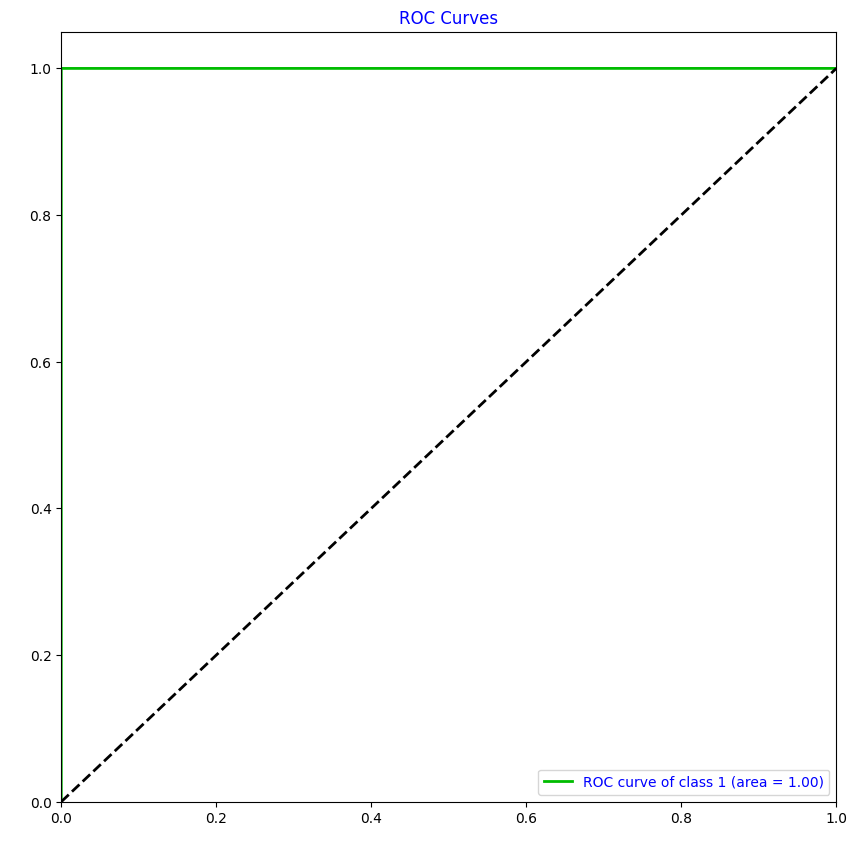

In [102]:
skplt.metrics.plot_roc(y_train, model.predict_proba(X_train), classes_to_plot= 1,plot_micro= False, plot_macro = False, figsize = (10,10))
plt.rcParams.update({'text.color': "blue", 'axes.labelcolor': "white"})

plt.show()

### Score de validacion

In [103]:
roc_auc_score(y_validation, model.predict_proba(X_validation)[:, 1])

0.9999994585674127

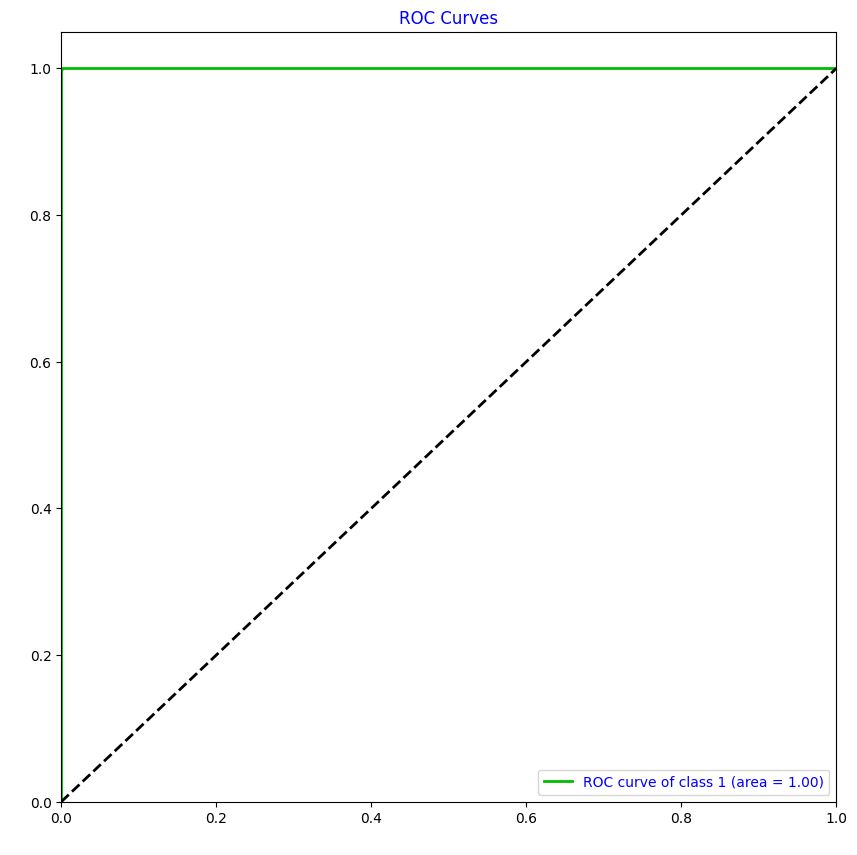

In [104]:
skplt.metrics.plot_roc(y_validation, model.predict_proba(X_validation), classes_to_plot= 1,plot_micro= False, plot_macro = False, figsize = (10,10))
plt.rcParams.update({'text.color': "blue", 'axes.labelcolor': "white"})

plt.show()

## Conclusion

Como este modelo resulta ser el mas optimo en cuanto a hiper-parametros resulta que es el modelo final y podemos medir la performance con el conjunto de datos para test.

## Score con AUC-ROC (en test)

In [105]:
roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

0.9999977195235499

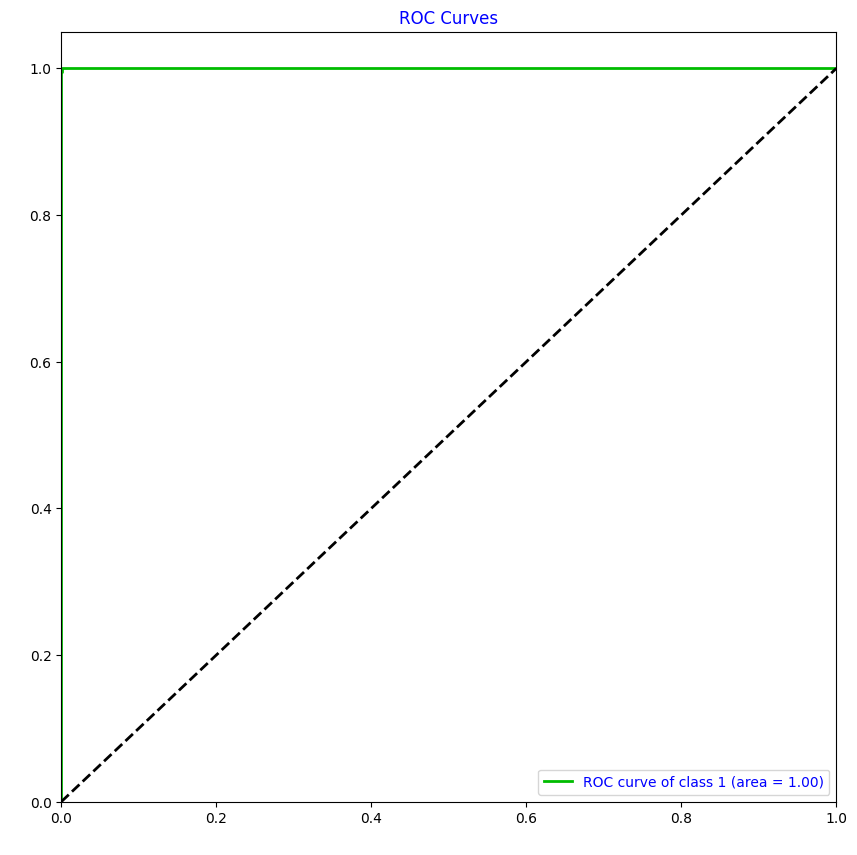

In [106]:
skplt.metrics.plot_roc(y_test, model.predict_proba(X_test), classes_to_plot= 1,plot_micro= False, plot_macro = False, figsize = (10,10))
plt.rcParams.update({'text.color': "blue", 'axes.labelcolor': "white"})

plt.show()

# CSV con predicciones

In [107]:
resultados = y_test.reset_index()
resultados.drop(columns=["class"], inplace=True)
resultados.columns = ["Registro"]

predicciones = pd.DataFrame(model.predict(X_test))
predicciones.columns = ["Prediccion"]

df = pd.concat([resultados, predicciones], axis=1)
df

,Registro,Prediccion
0,57412,1
1,39893,1
2,31795,1
3,7619,1
4,5776,0
...,...,...
6102,24653,0
6103,7559,1
6104,31693,0
6105,22687,1


In [108]:
df.to_csv('/content/drive/MyDrive/Organizacion de Datos/Colab Notebooks/TP2/predicciones_parte_IV.csv', index=False)

# Guardamos el modelo (Punto extra III - Ensamble)

In [109]:
with open('/content/drive/MyDrive/Organizacion de Datos/Colab Notebooks/TP2/xgb_model.pickle', 'wb') as archivo:
    pickle.dump(model, archivo)